# Problem A: Line Fitting

## Initialization

In [1]:
# Download CSV files
!wget -nc 140.114.76.113:8000/pA1.csv
!wget -nc 140.114.76.113:8000/pA2.csv

--2019-12-12 13:18:51--  http://140.114.76.113:8000/pA1.csv
Connecting to 140.114.76.113:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 604 [text/csv]
Saving to: ‘pA1.csv’

pA1.csv             100%[===================>]     604  --.-KB/s    in 0s      

2019-12-12 13:18:52 (105 MB/s) - ‘pA1.csv’ saved [604/604]

--2019-12-12 13:18:53--  http://140.114.76.113:8000/pA2.csv
Connecting to 140.114.76.113:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631 [text/csv]
Saving to: ‘pA2.csv’

pA2.csv             100%[===================>]     631  --.-KB/s    in 0s      

2019-12-12 13:18:53 (80.7 MB/s) - ‘pA2.csv’ saved [631/631]



In [0]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

In [0]:
torch.manual_seed(999) # Specify the seed
torch.backends.cudnn.deterministic = True # Make results reproducible

## A1

In [0]:
class Data(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        self.examples = pd.read_csv(csv_path).to_dict('records')
    
    def __getitem__(self, idx):
        example = self.examples[idx]
        x = torch.tensor(example['x'])
        y = torch.tensor(example['y'])
        return x, y
    
    def __len__(self):
        return len(self.examples)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.rand(1) * 0.001)
        self.b = nn.Parameter(torch.rand(1) * 0.001)
    
    def forward(self, x):
        h = self.a * x + self.b
        return h

In [6]:
# Set up CUDA
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model = Net().to(device)
data = Data('./pA1.csv')

# Set up hyperparameters
loader = DataLoader(data, batch_size=5)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
max_epochs = 300

# Set up history
history = {
    'loss': [],
    'a'   : [],
    'b'   : []
}

# Training
for epoch in tqdm(range(max_epochs)):
    for X, y in iter(loader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

        history['loss'].append(loss.detach().item())
        history['a'].append(model.a.item())
        history['b'].append(model.b.item())

print(model.a, model.b, sep='\n')

df = pd.read_csv('./pA1.csv')
X = torch.tensor(df['x'].values).to(device)
y = torch.tensor(df['y'].values).to(device)

100%|██████████| 300/300 [00:01<00:00, 161.79it/s]


Parameter containing:
tensor([4.9645], requires_grad=True)
Parameter containing:
tensor([4.0194], requires_grad=True)


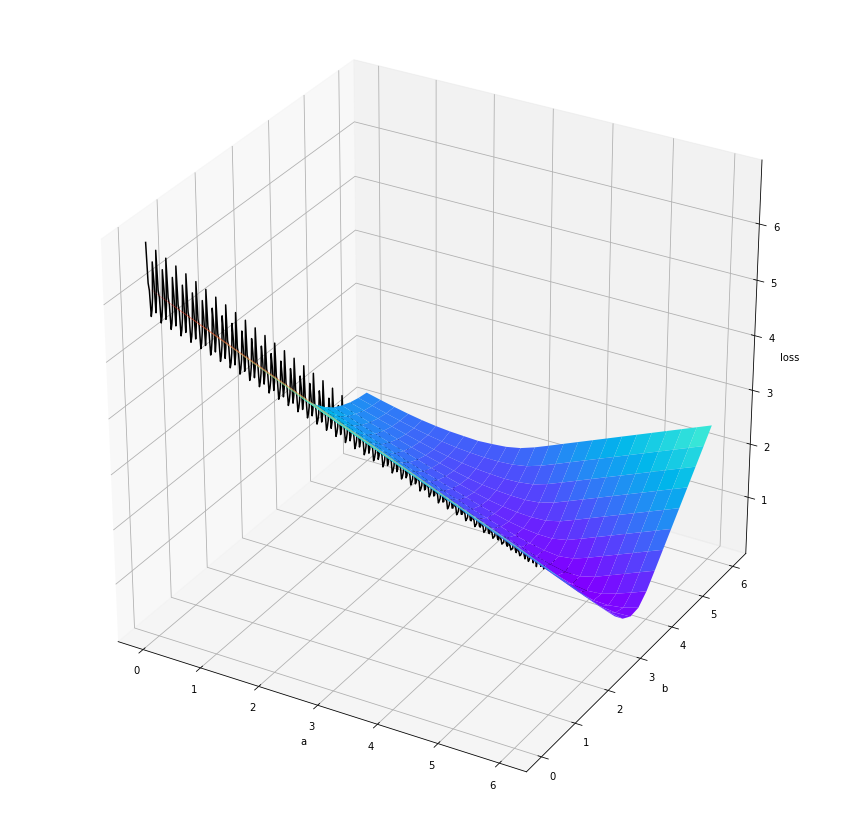

In [7]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('loss')

a = np.linspace(0, 6, 25)
b = np.linspace(0, 6, 25)
A, B = np.meshgrid(a, b)
df = pd.read_csv('./pA1.csv')
X = torch.tensor(df['x'].values)
y = torch.tensor(df['y'].values)
z_list = []
for ap, bp in zip(np.ravel(A), np.ravel(B)):
    y_pred = ap * X + bp
    loss = criterion(y, y_pred)
    z_list.append(loss.detach().item())
Z = np.array(z_list).reshape(A.shape)
ax.plot_surface(A, B, Z, cmap='rainbow')

loss = np.array(history['loss'])
a = np.array(history['a'])
b = np.array(history['b'])
ax.plot(a, b, loss, 'black')

plt.show()

## A2

In [0]:
class A2Data(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        raw_df = pd.read_csv(csv_path)
        self.df = raw_df.assign(x2=raw_df['x'] ** 2)
    
    def __getitem__(self, idx):
        example = self.df.iloc[idx, :]
        x = torch.tensor(example[['x2', 'x']])
        y = torch.tensor(example['y'])
        return x, y

    def __len__(self):
        return self.df.shape[0]

class A2Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(2, 1)
    
    def forward(self, xb):
        return self.lin(xb)

def fit(epochs, model, loss_func, opt, train_dl):
    loss_history = { 'iter': [], 'loss': [] }
    iter_num = 0

    for epoch in tqdm(range(epochs)):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb.unsqueeze(1))

            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_history['loss'].append(loss.item())
            loss_history['iter'].append(iter_num)
            iter_num += 1

    print(model.lin.weight, model.lin.bias)

    return loss_history

In [9]:
lr = 1e-1    # learning rate
epochs = 100 # max number of epochs
bs = 5       # batch size

dl = DataLoader(A2Data('./pA2.csv'), batch_size=bs)
model = A2Linear()

opt = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = F.l1_loss

history = fit(epochs, model, loss_func, opt, dl)

100%|██████████| 100/100 [00:06<00:00, 16.14it/s]

Parameter containing:
tensor([[-1.9836,  0.9669]], requires_grad=True) Parameter containing:
tensor([3.9858], requires_grad=True)


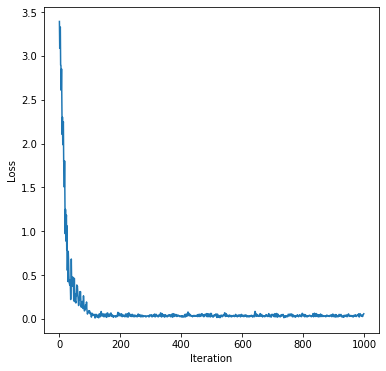

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.plot(history['iter'], history['loss'])

plt.show()